<a href="https://colab.research.google.com/github/berilldindar/EmotionDetection/blob/main/DuyguTanimaRESNET50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/drive')
%cd /drive

Mounted at /drive
/drive


In [ ]:
import os
os.chdir('/drive/My Drive/DuyguTanima')

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import keras
from keras.models import Sequential,Model,model_from_json
from keras.layers import Dense,Conv2D,Activation,MaxPool2D,Flatten,Dropout,BatchNormalization
from keras.utils import np_utils
from keras_preprocessing import image

In [ ]:
root='/drive/My Drive/DuyguTanima/'
data=pd.read_csv(root+'data/fer2013/fer2013.csv')
data.shape

(35887, 3)

In [ ]:
data["Usage"].value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

In [ ]:
np.unique(data["Usage"].values.ravel())
print('Eğitim setindeki örnek sayısı:%d'%(len(data[data.Usage== "Training"])))

Eğitim setindeki örnek sayısı:28709


In [ ]:
train_data= data[data.Usage== "Training"]

In [ ]:
train_pixels=train_data.pixels.str.split(" ").tolist()

train_pixels= pd.DataFrame(train_pixels,dtype=int)
train_images=train_pixels.values
train_images=train_images.astype(np.float)

print(train_images)
print(train_images.shape)

[[ 70.  80.  82. ... 106. 109.  82.]
 [151. 150. 147. ... 193. 183. 184.]
 [231. 212. 156. ...  88. 110. 152.]
 ...
 [ 74.  81.  87. ... 188. 187. 187.]
 [222. 227. 203. ... 136. 136. 134.]
 [195. 199. 205. ...   6.  15.  38.]]
(28709, 2304)


In [ ]:
def show(img):
    show_image = img.reshape(48,48)

    plt.axis('off')
    plt.imshow(show_image, cmap='gray')

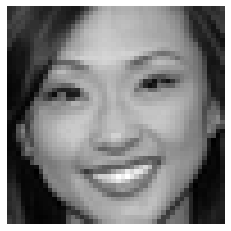

In [ ]:
show(train_images[23699])

In [ ]:
train_labels_flat=train_data['emotion'].values.ravel()
train_labels_count=np.unique(train_labels_flat).shape[0]
print('Farklı yüz ifadelerinin sayısı: %d'%train_labels_count)

Farklı yüz ifadelerinin sayısı: 7


In [ ]:
def dense_to_one_hot(labels_dense,num_classes):
  num_labels =labels_dense.shape[0]
  index_offset=np.arange(num_labels)* num_classes
  labels_one_hot=np.zeros((num_labels,num_classes))
  labels_one_hot.flat[index_offset+labels_dense.ravel()] =1
  return labels_one_hot

In [ ]:
y_train = dense_to_one_hot(train_labels_flat,train_labels_count)

y_train = y_train.astype(np.uint8)
print(y_train.shape)


(28709, 7)


In [ ]:
np.unique(data["Usage"].values.ravel())
print('Test setindeki örnek sayısı:%d'%(len(data[data.Usage== "PublicTest"])))

Test setindeki örnek sayısı:3589


In [ ]:
test_data=data[data.Usage == "PublicTest"]
test_pixels=test_data.pixels.str.split(" ").tolist()

test_pixels = pd.DataFrame(test_pixels,dtype=int)
test_images=test_pixels.values
test_images=test_images.astype(np.float)

print(test_images)
print(test_images.shape)

[[254. 254. 254. ...  42. 129. 180.]
 [156. 184. 198. ... 172. 167. 161.]
 [ 69. 118.  61. ...  88.  87.  90.]
 ...
 [255. 255. 255. ...  48.  50.  46.]
 [ 33.  25.  31. ...   4.   5.   4.]
 [ 61.  63.  59. ... 113. 165. 180.]]
(3589, 2304)


In [ ]:
test_labels_flat=test_data['emotion'].values.ravel()
test_labels_count=np.unique(test_labels_flat).shape[0]

y_test=dense_to_one_hot(test_labels_flat,test_labels_count)
y_test=y_test.astype(np.uint8)
print(y_test.shape)



(3589, 7)


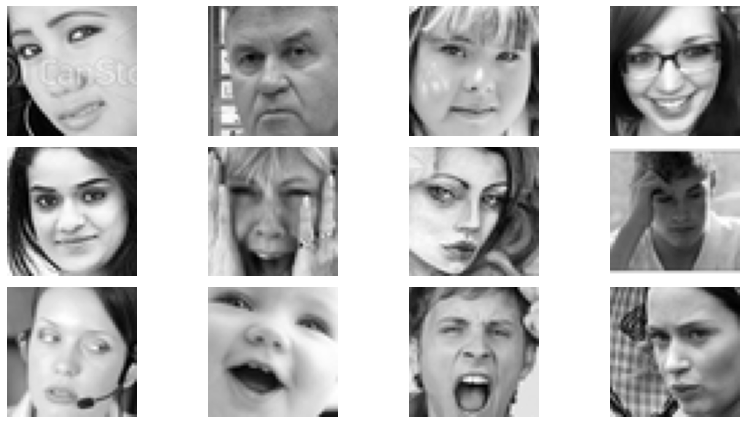

In [ ]:
plt.figure(0,figsize=(12,6))
for i in range (1,13):
  plt.subplot(3,4,i)
  plt.axis('off')

  image=test_images[i].reshape(48,48)
  plt.imshow(image,cmap="gray")

plt.tight_layout()
plt.show()

In [ ]:
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline


In [ ]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    

    F1, F2, F3 = filters
    
    X_shortcut = X
   
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
   
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    X = Add()([X_shortcut,X])
    X = Activation("relu")(X)
        
    return X

In [ ]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a',padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
  
    X = Conv2D(F2, (f, f), strides = (1,1), name = conv_name_base + '2b',padding = 'same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(F3, (1, 1), strides = (1,1), name = conv_name_base + '2c',padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

 #shortcut katmanı
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1',padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    
    X = Add()([X_shortcut,X])
    X = Activation("relu")(X)
        
    return X

In [ ]:
def Net50(input_shape = (48,48,1), classes = 7):
  
    
    X_input = Input(input_shape)

    X = X_input
    # Stage 1
    X = Conv2D(8, (3, 3), strides = (1, 1), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
 

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [32, 32, 128], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [32, 32, 128], stage=2, block='b')
    X = identity_block(X, 3, [32, 32, 128], stage=2, block='c')


    # Stage 3 
    X = convolutional_block(X, f = 3, filters = [64,64,256], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [64,64,256], stage=3, block='b')
    X = identity_block(X, 3, [64,64,256], stage=3, block='c')
    X = identity_block(X, 3, [64,64,256], stage=3, block='d')

    # Stage 4 
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='d')
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='e')
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='f')

    # Stage 5 
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=5, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=5, block='c')

    
    X = AveragePooling2D((2,2), name='average_pool')(X)
    
    # output katmanı
    X = Flatten()(X)
    X = Dense(512, activation = 'relu', name='fullyconnect512' , kernel_initializer = glorot_uniform(seed=0))(X)
    X = Dense(classes, activation='softmax', name='fullyconnect' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
   
    model = Model(inputs = X_input, outputs = X, name='Net50')

    return model

In [ ]:
from keras.optimizers import Adam
model = Net50(input_shape = (48, 48, 1), classes = 7)
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "Net50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 46, 46, 8)    80          input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 46, 46, 8)    32          conv1[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 46, 46, 8)    0           bn_conv1[0][0]                   
______________________________________________________________________________________________

In [ ]:
x_train=train_images.reshape(-1,48,48,1)
x_test=test_images.reshape(-1,48,48,1)

print("Train:",x_train.shape)
print("Test:",x_test.shape)

Train: (28709, 48, 48, 1)
Test: (3589, 48, 48, 1)


In [ ]:
print("Train:",y_train.shape)
print("Test:",y_test.shape)

Train: (28709, 7)
Test: (3589, 7)


In [ ]:
epochs=10
batchSize=64
hist=model.fit(x_train,y_train,
               epochs=epochs,
               shuffle=True,
               batch_size=batchSize,
               validation_data=(x_test,y_test)
)

Epoch 1/10
449/449 [==============================] - 137s 182ms/step - loss: 4.0835 - accuracy: 0.2279 - val_loss: 1.6971 - val_accuracy: 0.3221
Epoch 2/10
449/449 [==============================] - 79s 175ms/step - loss: 1.5629 - accuracy: 0.3910 - val_loss: 1.4574 - val_accuracy: 0.4377
Epoch 3/10
449/449 [==============================] - 80s 178ms/step - loss: 1.3451 - accuracy: 0.4833 - val_loss: 1.4194 - val_accuracy: 0.4645
Epoch 4/10
449/449 [==============================] - 80s 178ms/step - loss: 1.2412 - accuracy: 0.5191 - val_loss: 1.3028 - val_accuracy: 0.4982
Epoch 5/10
449/449 [==============================] - 80s 178ms/step - loss: 1.1283 - accuracy: 0.5637 - val_loss: 1.3826 - val_accuracy: 0.5001
Epoch 6/10
449/449 [==============================] - 80s 178ms/step - loss: 1.0754 - accuracy: 0.5945 - val_loss: 1.2424 - val_accuracy: 0.5302
Epoch 7/10
449/449 [==============================] - 80s 178ms/step - loss: 0.9904 - accuracy: 0.6250 - val_loss: 1.3190 - val_a

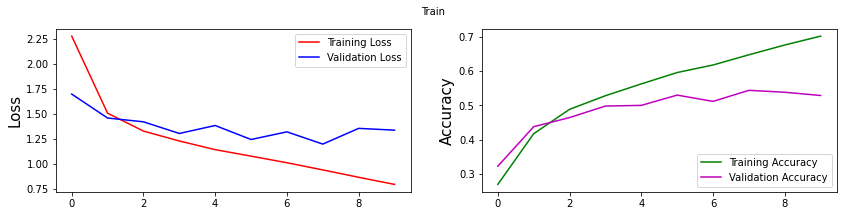

In [ ]:
plt.figure(figsize=(14,3))
plt.subplot(1,2,1)
plt.suptitle('Train',fontsize=10)
plt.ylabel('Loss',fontsize=15)
plt.plot(hist.history['loss'],color='r',label='Training Loss')
plt.plot(hist.history['val_loss'],color='b',label='Validation Loss')
plt.legend(loc='upper right')


plt.subplot(1,2,2)
plt.ylabel('Accuracy',fontsize=15)
plt.plot(hist.history['accuracy'],color='g',label='Training Accuracy')
plt.plot(hist.history['val_accuracy'],color='m',label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
test=data[['emotion',"pixels"]][data["Usage"]=="PrivateTest"]
test["pixels"]=test["pixels"].apply(lambda im:np.fromstring(im,sep=' '))


In [ ]:
x_test_private=np.vstack(test["pixels"].values)
y_test_private=np.array(test["emotion"])


In [ ]:
x_test_private=x_test_private.reshape(-1,48,48,1)
y_test_private=np_utils.to_categorical(y_test_private)
x_test_private.shape,y_test_private.shape

((3589, 48, 48, 1), (3589, 7))

In [ ]:
score=model.evaluate(x_test_private,y_test_private, verbose=0)
print("PrivateTest üzerindeki doğruluk durumu:",score)

PrivateTest üzerindeki doğruluk durumu: [1.3269686698913574, 0.5358038544654846]


In [ ]:
from keras.models import load_model
from PIL import Image
from keras_preprocessing import image

In [ ]:
os.chdir('/drive/My Drive/DuyguTanima/images')

In [ ]:
!ls

'WhatsApp Image 2021-03-14 at 19.03.42 (1).jpeg'
'WhatsApp Image 2021-03-14 at 19.03.42 (2).jpeg'
'WhatsApp Image 2021-03-14 at 19.03.42 (3).jpeg'
'WhatsApp Image 2021-03-14 at 19.03.42 (4).jpeg'
'WhatsApp Image 2021-03-14 at 19.03.42 (5).jpeg'
'WhatsApp Image 2021-03-14 at 19.03.42.jpeg'
'WhatsApp Image 2021-03-14 at 19.13.32 (10).jpeg'
'WhatsApp Image 2021-03-14 at 19.13.32 (11).jpeg'
'WhatsApp Image 2021-03-14 at 19.13.32 (12).jpeg'
'WhatsApp Image 2021-03-14 at 19.13.32 (13).jpeg'
'WhatsApp Image 2021-03-14 at 19.13.32 (14).jpeg'
'WhatsApp Image 2021-03-14 at 19.13.32 (1).jpeg'
'WhatsApp Image 2021-03-14 at 19.13.32 (2).jpeg'
'WhatsApp Image 2021-03-14 at 19.13.32 (3).jpeg'
'WhatsApp Image 2021-03-14 at 19.13.32 (4).jpeg'
'WhatsApp Image 2021-03-14 at 19.13.32 (5).jpeg'
'WhatsApp Image 2021-03-14 at 19.13.32 (6).jpeg'
'WhatsApp Image 2021-03-14 at 19.13.32 (7).jpeg'
'WhatsApp Image 2021-03-14 at 19.13.32 (8).jpeg'
'WhatsApp Image 2021-03-14 at 19.13.32 (9).jpeg'
'WhatsApp Image 202

In [ ]:
image_path=root+"images/WhatsApp Image 2021-03-14 at 19.03.42.jpeg"
test_image_original=image.load_img(image_path)
test_image=image.load_img(image_path,target_size=(48,48),grayscale=True)
test_data=image.img_to_array(test_image)

test_data=np.expand_dims(test_data,axis=0)
test_data=np.vstack([test_data])

results=model.predict(test_data,batch_size=1)
results

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


array([[1.07983783e-01, 7.72441382e-08, 3.45618837e-03, 8.38617682e-01,
        1.36621455e-02, 1.40760536e-03, 3.48724760e-02]], dtype=float32)

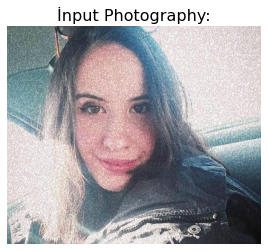

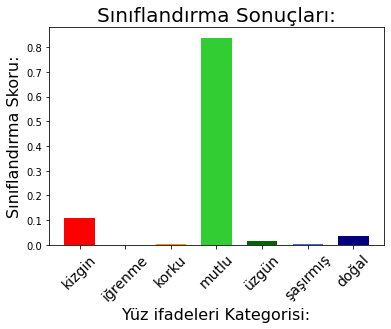

Sınıflandırma sonucu en yüksek oranla: mutlu


In [ ]:
class_names=['kizgin','iğrenme','korku','mutlu','üzgün','şaşırmış','doğal']
ind=0.1+0.6*np.arange(len(class_names))
width=0.4

color_list=['red','orangered','darkorange','limegreen','darkgreen','royalblue','navy']

plt.imshow(test_image_original)
plt.title('İnput Photography:',fontsize=16)
plt.axis('off')
plt.show()


for i in range(len(class_names)):
  plt.bar(ind[i], results[0][i], width, color=color_list[i])


plt.title('Sınıflandırma Sonuçları:', fontsize=20)
plt.xlabel('Yüz ifadeleri Kategorisi:',fontsize=16)
plt.ylabel('Sınıflandırma Skoru:',fontsize=16)
plt.xticks(ind,class_names,rotation=45,fontsize=14)
plt.show()

print('Sınıflandırma sonucu en yüksek oranla:',class_names[np.argmax(results)])

